In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [167]:
def load_data(data_folder = '', size = 150, batch_size = 32, num_workers = 8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    }

    imagenets = {
        'train': ImageFolder(data_folder + '\\train', transform=data_transforms['train']),
        'val': ImageFolder(data_folder + '\\val', transform=data_transforms['val']),
        'test': ImageFolder(data_folder + '\\test', transform=data_transforms['test'])
    }

    data_loader = {
        x: torch.utils.data.DataLoader(imagenets[x],
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=num_workers) for x in ['train', 'val', 'test']
    }
    print('Datasets Loaded')
    return data_loader

In [163]:
def load_labels(label_folder = ''):
    f = open(label_folder, "r")
    labels_dict = {}
    labels_list = []
    for line in f:
        split = line.split(maxsplit=1)
        label_id = split[0]
        label = split[1].rstrip()
        labels_dict[label_id] = label
        labels_list.append(label)
    return labels_list, labels_dict

In [164]:
data = load_data('E:\\Data\\tiny-imagenet-200')
data

Datasets Loaded


{'train': <torch.utils.data.dataloader.DataLoader at 0x24df2085630>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x24df20852e8>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x24df2085d68>}

In [165]:
labels_list, labels_dict = load_labels("E:\Data\\tiny-imagenet-200\\words.txt")
labels_list[1:4]

['physical entity', 'abstraction, abstract entity', 'thing']

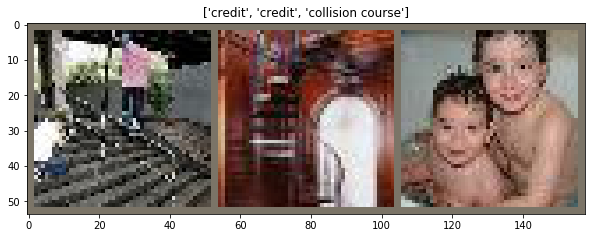

In [170]:
# As our images are normalized we have to denormalize them and 
# convert them to numpy arrays.
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause is necessary to display images correctly
    
images, labels = next(iter(data['train']))
grid_img = make_grid(images[13:16], nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[13:16]])